# MMSegmentation Tutorial
Welcome to MMSegmentation! 

In this tutorial, we demo
* How to do inference with MMSeg trained weight
* How to train on your own dataset and visualize the results. 

## Install MMSegmentation
This step may take several minutes. 

We use PyTorch 1.10 and CUDA 11.1 for this tutorial. You may install other versions by change the version number in pip install command. 

In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [1]:
# Install PyTorch
!pip install torch==1.12.0 torchvision --extra-index-url https://download.pytorch.org/whl/cu113
# Install MMCV
!pip install openmim
!mim install mmcv-full==1.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/index.html


In [2]:
!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 12947, done.
remote: Total 12947 (delta 0), reused 0 (delta 0), pack-reused 12947
Receiving objects: 100% (12947/12947), 15.54 MiB | 29.91 MiB/s, done.
Resolving deltas: 100% (9357/9357), done.
/content/mmsegmentation
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/mmsegmentation
  Running setup.py develop for mmsegmentation


In [3]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.12.0+cu113 True
0.29.1


## Run Inference with MMSeg trained weight

In [4]:
!mkdir checkpoints
!wget https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth -P checkpoints

--2022-12-29 08:08:34--  https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 8.38.121.207, 8.38.121.213, 8.38.121.212, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|8.38.121.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196205945 (187M) [application/octet-stream]
Saving to: ‘checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth’

pspnet_r50-d8_512x1 100%[===================>] 187.12M  17.8MB/s    in 10s     

2022-12-29 08:08:45 (18.0 MB/s) - ‘checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth’ saved [196205945/196205945]



In [ ]:
!unzip /content/anomaly_dataset.zip -d /content/mmsegmentation

In [6]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

In [7]:
config_file = 'configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py'
checkpoint_file = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

In [8]:
# build the model from a config file and a checkpoint file
model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth


In [9]:
# test a single image
img = 'demo/demo.png'
result = inference_segmentor(model, img)

/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


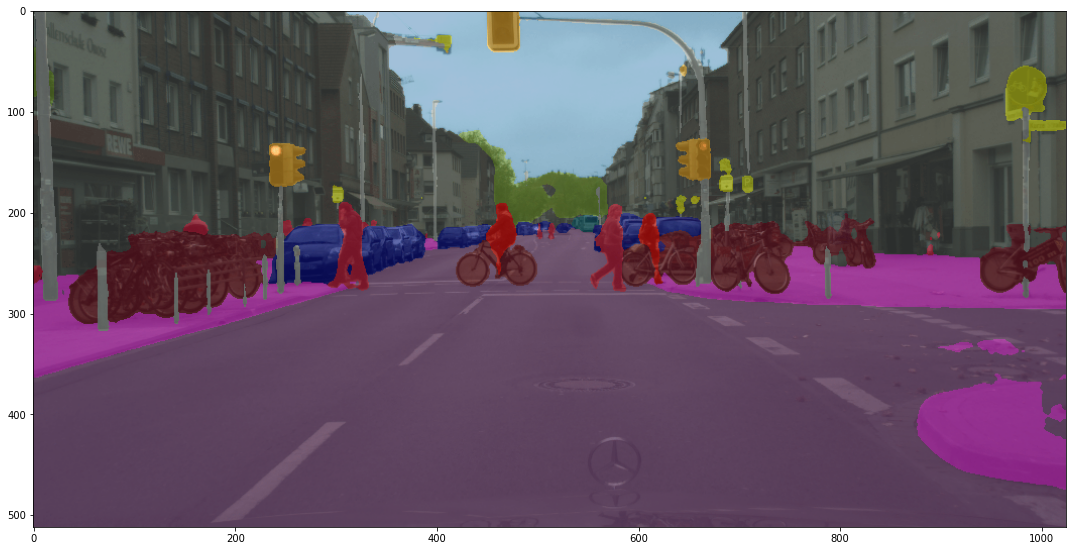

In [10]:
# show the results
show_result_pyplot(model, img, result, get_palette('cityscapes'))

## Train a semantic segmentation model on a new dataset

To train on a customized dataset, the following steps are necessary. 
1. Add a new dataset class. 
2. Create a config file accordingly. 
3. Perform training and evaluation. 

### Add a new dataset

Datasets in MMSegmentation require image and semantic segmentation maps to be placed in folders with the same prefix. To support a new dataset, we may need to modify the original file structure. 

In this tutorial, we give an example of converting the dataset. You may refer to [docs](https://github.com/open-mmlab/mmsegmentation/blob/master/docs/en/tutorials/customize_datasets.md#customize-datasets-by-reorganizing-data) for details about dataset reorganization. 

We use [Stanford Background Dataset](http://dags.stanford.edu/projects/scenedataset.html) as an example. The dataset contains 715 images chosen from existing public datasets [LabelMe](http://labelme.csail.mit.edu), [MSRC](http://research.microsoft.com/en-us/projects/objectclassrecognition), [PASCAL VOC](http://pascallin.ecs.soton.ac.uk/challenges/VOC) and [Geometric Context](http://www.cs.illinois.edu/homes/dhoiem/). Images from these datasets are mainly outdoor scenes, each containing approximately 320-by-240 pixels. 
In this tutorial, we use the region annotations as labels. There are 8 classes in total, i.e. sky, tree, road, grass, water, building, mountain, and foreground object. 

In [ ]:
# download and unzip
!wget http://dags.stanford.edu/data/iccv09Data.tar.gz -O stanford_background.tar.gz
!tar xf stanford_background.tar.gz

In [ ]:
!unzip /content/anomaly_dataset.zip -d /content/mmsegmentation

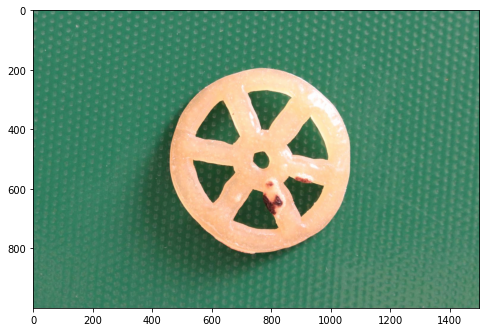

In [8]:
# Let's take a look at the dataset
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('/content/mmsegmentation/anomaly_dataset/images/004.JPG')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

We need to convert the annotation into semantic map format as an image.

In [9]:
import os.path as osp
import numpy as np
from PIL import Image
# convert dataset annotation to semantic segmentation map
data_root = 'anomaly_dataset'
img_dir = 'images'
ann_dir = 'labels'
# define class and plaette for better visualization
classes = ('anomalous region' , 'background')
palette = [[255,0,0],[0,0,0]]


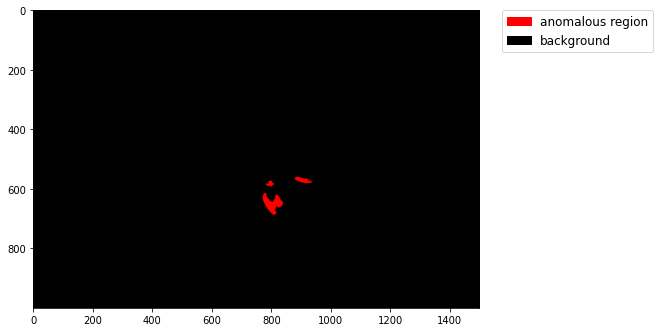

In [10]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open('/content/mmsegmentation/anomaly_dataset/labels/004.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(2)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [11]:
cd /content/mmsegmentation

/content/mmsegmentation


In [12]:
# split train/val set randomly
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

After downloading the data, we need to implement `load_annotations` function in the new dataset class `StanfordBackgroundDataset`.

In [13]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class VisA(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.JPG', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

    

### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [14]:
from mmcv import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py')

Since the given config is used to train PSPNet on the cityscapes dataset, we need to modify it accordingly for our new dataset.  

In [15]:
from mmseg.apis import set_random_seed
from mmseg.utils import get_device

# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 2
cfg.model.auxiliary_head.num_classes = 2

# Modify dataset type and path
cfg.dataset_type = 'VisA'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 2
cfg.data.workers_per_gpu=2

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
#cfg.crop_size = (256, 256)
cfg.crop_size = (1024, 1024)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 2.0)),# img_scale=(320, 240)
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),#img_scale=(320, 240)
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 1000
cfg.log_config.interval = 100
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 200

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = get_device()

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_index=2,
        channels=256,
        num_convs=1,
        concat_input=F

### Train and Evaluation

In [ ]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2022-12-29 10:02:35,593 - mmseg - INFO - Loaded 48 images
/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/content/mmsegmentation/mmseg/models/decode_heads/decode_head.py:94: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert seg_logist into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
2022-12-29 10:02:40,156 - mmseg - INFO - Loaded 12 images
2022-12-29 10:02:40,160 - mmseg - INFO - load checkpoint from local path: checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
2022-12-29 10:02:40,382 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 12/12, 6.9 task/s, elapsed: 2s, ETA:     0s

2022-12-29 10:02:50,218 - mmseg - INFO - per class results:
2022-12-29 10:02:50,221 - mmseg - INFO - 
+------------------+-------+-------+
|      Class       |  IoU  |  Acc  |
+------------------+-------+-------+
| anomalous region | 95.25 | 100.0 |
|    background    |  0.0  |  0.0  |
+------------------+-------+-------+
2022-12-29 10:02:50,224 - mmseg - INFO - Summary:
2022-12-29 10:02:50,227 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 95.25 | 47.63 | 50.0 |
+-------+-------+------+
2022-12-29 10:02:50,230 - mmseg - INFO - Iter(val) [12]	aAcc: 0.9525, mIoU: 0.4763, mAcc: 0.5000, IoU.anomalous region: 0.9525, IoU.background: 0.0000, Acc.anomalous region: 1.0000, Acc.background: 0.0000
2022-12-29 10:02:54,196 - mmseg - INFO - Iter [30/600]	lr: 9.568e-03, eta: 0:04:16, time: 0.573, data_time: 0.391, memory: 1334, decode.loss_focal: 0.0207, decode.acc_seg: 94.5994, aux.loss_focal: 0.0214, aux.acc_seg: 94.5994, loss: 0.0421
2022-12-29 10:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 12/12, 7.9 task/s, elapsed: 2s, ETA:     0s

2022-12-29 10:02:57,456 - mmseg - INFO - per class results:
2022-12-29 10:02:57,459 - mmseg - INFO - 
+------------------+-------+-------+
|      Class       |  IoU  |  Acc  |
+------------------+-------+-------+
| anomalous region | 95.25 | 100.0 |
|    background    |  0.0  |  0.0  |
+------------------+-------+-------+
2022-12-29 10:02:57,462 - mmseg - INFO - Summary:
2022-12-29 10:02:57,466 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 95.25 | 47.63 | 50.0 |
+-------+-------+------+
2022-12-29 10:02:57,468 - mmseg - INFO - Iter(val) [12]	aAcc: 0.9525, mIoU: 0.4763, mAcc: 0.5000, IoU.anomalous region: 0.9525, IoU.background: 0.0000, Acc.anomalous region: 1.0000, Acc.background: 0.0000
2022-12-29 10:03:01,369 - mmseg - INFO - Saving checkpoint at 50 iterations
2022-12-29 10:03:04,398 - mmseg - INFO - Iter [50/600]	lr: 9.269e-03, eta: 0:04:21, time: 0.849, data_time: 0.367, memory: 1334, decode.loss_focal: 0.0274, decode.acc_seg: 90.369

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 12/12, 7.7 task/s, elapsed: 2s, ETA:     0s

2022-12-29 10:03:07,798 - mmseg - INFO - per class results:
2022-12-29 10:03:07,801 - mmseg - INFO - 
+------------------+-------+-------+
|      Class       |  IoU  |  Acc  |
+------------------+-------+-------+
| anomalous region | 95.25 | 100.0 |
|    background    |  0.02 |  0.02 |
+------------------+-------+-------+
2022-12-29 10:03:07,803 - mmseg - INFO - Summary:
2022-12-29 10:03:07,809 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 95.25 | 47.63 | 50.01 |
+-------+-------+-------+
2022-12-29 10:03:07,810 - mmseg - INFO - Iter(val) [12]	aAcc: 0.9525, mIoU: 0.4763, mAcc: 0.5001, IoU.anomalous region: 0.9525, IoU.background: 0.0002, Acc.anomalous region: 1.0000, Acc.background: 0.0002
2022-12-29 10:03:09,563 - mmseg - INFO - Iter [70/600]	lr: 8.969e-03, eta: 0:03:38, time: 0.334, data_time: 0.163, memory: 1334, decode.loss_focal: 0.0240, decode.acc_seg: 94.4614, aux.loss_focal: 0.0224, aux.acc_seg: 94.4332, loss: 0.0464
2022-12-2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 12/12, 7.6 task/s, elapsed: 2s, ETA:     0s

2022-12-29 10:03:15,107 - mmseg - INFO - per class results:
2022-12-29 10:03:15,110 - mmseg - INFO - 
+------------------+-------+-------+
|      Class       |  IoU  |  Acc  |
+------------------+-------+-------+
| anomalous region | 95.25 | 100.0 |
|    background    |  0.0  |  0.0  |
+------------------+-------+-------+
2022-12-29 10:03:15,114 - mmseg - INFO - Summary:
2022-12-29 10:03:15,119 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 95.25 | 47.63 | 50.0 |
+-------+-------+------+
2022-12-29 10:03:15,124 - mmseg - INFO - Iter(val) [12]	aAcc: 0.9525, mIoU: 0.4763, mAcc: 0.5000, IoU.anomalous region: 0.9525, IoU.background: 0.0000, Acc.anomalous region: 1.0000, Acc.background: 0.0000
2022-12-29 10:03:16,894 - mmseg - INFO - Iter [90/600]	lr: 8.668e-03, eta: 0:03:25, time: 0.337, data_time: 0.164, memory: 1334, decode.loss_focal: 0.0134, decode.acc_seg: 96.4049, aux.loss_focal: 0.0134, aux.acc_seg: 96.4049, loss: 0.0268
2022-12-29 10:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 12/12, 6.2 task/s, elapsed: 2s, ETA:     0s

2022-12-29 10:03:25,214 - mmseg - INFO - per class results:
2022-12-29 10:03:25,219 - mmseg - INFO - 
+------------------+-------+-------+
|      Class       |  IoU  |  Acc  |
+------------------+-------+-------+
| anomalous region | 95.25 | 100.0 |
|    background    |  0.0  |  0.0  |
+------------------+-------+-------+
2022-12-29 10:03:25,220 - mmseg - INFO - Summary:
2022-12-29 10:03:25,224 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 95.25 | 47.63 | 50.0 |
+-------+-------+------+
2022-12-29 10:03:25,226 - mmseg - INFO - Iter(val) [12]	aAcc: 0.9525, mIoU: 0.4763, mAcc: 0.5000, IoU.anomalous region: 0.9525, IoU.background: 0.0000, Acc.anomalous region: 1.0000, Acc.background: 0.0000
2022-12-29 10:03:27,089 - mmseg - INFO - Iter [110/600]	lr: 8.366e-03, eta: 0:03:26, time: 0.381, data_time: 0.199, memory: 1334, decode.loss_focal: 0.0225, decode.acc_seg: 94.1784, aux.loss_focal: 0.0208, aux.acc_seg: 94.1784, loss: 0.0433
2022-12-29 10

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 12/12, 7.9 task/s, elapsed: 2s, ETA:     0s

2022-12-29 10:03:30,395 - mmseg - INFO - per class results:
2022-12-29 10:03:30,400 - mmseg - INFO - 
+------------------+-------+-------+
|      Class       |  IoU  |  Acc  |
+------------------+-------+-------+
| anomalous region | 95.31 | 100.0 |
|    background    |  1.29 |  1.29 |
+------------------+-------+-------+
2022-12-29 10:03:30,403 - mmseg - INFO - Summary:
2022-12-29 10:03:30,405 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 95.31 | 48.3 | 50.64 |
+-------+------+-------+
2022-12-29 10:03:30,406 - mmseg - INFO - Iter(val) [12]	aAcc: 0.9531, mIoU: 0.4830, mAcc: 0.5064, IoU.anomalous region: 0.9531, IoU.background: 0.0129, Acc.anomalous region: 1.0000, Acc.background: 0.0129
2022-12-29 10:03:34,370 - mmseg - INFO - Iter [130/600]	lr: 8.062e-03, eta: 0:03:14, time: 0.550, data_time: 0.368, memory: 1334, decode.loss_focal: 0.0164, decode.acc_seg: 94.8046, aux.loss_focal: 0.0178, aux.acc_seg: 94.6980, loss: 0.0342
2022-12-29 10

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 12/12, 7.9 task/s, elapsed: 2s, ETA:     0s

2022-12-29 10:03:37,683 - mmseg - INFO - per class results:
2022-12-29 10:03:37,686 - mmseg - INFO - 
+------------------+------+-------+
|      Class       | IoU  |  Acc  |
+------------------+------+-------+
| anomalous region | 95.5 | 99.98 |
|    background    | 5.97 |  5.99 |
+------------------+------+-------+
2022-12-29 10:03:37,689 - mmseg - INFO - Summary:
2022-12-29 10:03:37,695 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 95.52 | 50.74 | 52.99 |
+-------+-------+-------+
2022-12-29 10:03:37,697 - mmseg - INFO - Iter(val) [12]	aAcc: 0.9552, mIoU: 0.5074, mAcc: 0.5299, IoU.anomalous region: 0.9550, IoU.background: 0.0597, Acc.anomalous region: 0.9998, Acc.background: 0.0599
2022-12-29 10:03:41,660 - mmseg - INFO - Saving checkpoint at 150 iterations
2022-12-29 10:03:43,833 - mmseg - INFO - Iter [150/600]	lr: 7.757e-03, eta: 0:03:09, time: 0.769, data_time: 0.366, memory: 1334, decode.loss_focal: 0.0355, decode.acc_seg: 88.15

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 12/12, 7.8 task/s, elapsed: 2s, ETA:     0s

2022-12-29 10:03:47,276 - mmseg - INFO - per class results:
2022-12-29 10:03:47,278 - mmseg - INFO - 
+------------------+-------+-------+
|      Class       |  IoU  |  Acc  |
+------------------+-------+-------+
| anomalous region | 95.57 | 99.98 |
|    background    |  7.54 |  7.58 |
+------------------+-------+-------+
2022-12-29 10:03:47,280 - mmseg - INFO - Summary:
2022-12-29 10:03:47,281 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 95.59 | 51.56 | 53.78 |
+-------+-------+-------+
2022-12-29 10:03:47,283 - mmseg - INFO - Iter(val) [12]	aAcc: 0.9559, mIoU: 0.5156, mAcc: 0.5378, IoU.anomalous region: 0.9557, IoU.background: 0.0754, Acc.anomalous region: 0.9998, Acc.background: 0.0758
2022-12-29 10:03:51,263 - mmseg - INFO - Iter [170/600]	lr: 7.451e-03, eta: 0:02:58, time: 0.554, data_time: 0.370, memory: 1334, decode.loss_focal: 0.0170, decode.acc_seg: 95.2994, aux.loss_focal: 0.0184, aux.acc_seg: 94.6099, loss: 0.0354
2022-12-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 12/12, 7.8 task/s, elapsed: 2s, ETA:     0s

2022-12-29 10:03:54,607 - mmseg - INFO - per class results:
2022-12-29 10:03:54,610 - mmseg - INFO - 
+------------------+-------+-------+
|      Class       |  IoU  |  Acc  |
+------------------+-------+-------+
| anomalous region | 95.69 | 99.96 |
|    background    | 10.39 | 10.47 |
+------------------+-------+-------+
2022-12-29 10:03:54,612 - mmseg - INFO - Summary:
2022-12-29 10:03:54,616 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 95.71 | 53.04 | 55.21 |
+-------+-------+-------+
2022-12-29 10:03:54,617 - mmseg - INFO - Iter(val) [12]	aAcc: 0.9571, mIoU: 0.5304, mAcc: 0.5521, IoU.anomalous region: 0.9569, IoU.background: 0.1039, Acc.anomalous region: 0.9996, Acc.background: 0.1047
2022-12-29 10:03:56,439 - mmseg - INFO - Iter [190/600]	lr: 7.143e-03, eta: 0:02:43, time: 0.337, data_time: 0.160, memory: 1334, decode.loss_focal: 0.0201, decode.acc_seg: 92.1367, aux.loss_focal: 0.0209, aux.acc_seg: 91.5732, loss: 0.0410
2022-12-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 12/12, 6.5 task/s, elapsed: 2s, ETA:     0s

2022-12-29 10:04:04,521 - mmseg - INFO - per class results:
2022-12-29 10:04:04,523 - mmseg - INFO - 
+------------------+-------+-------+
|      Class       |  IoU  |  Acc  |
+------------------+-------+-------+
| anomalous region | 96.05 | 99.83 |
|    background    | 20.36 | 21.04 |
+------------------+-------+-------+
2022-12-29 10:04:04,526 - mmseg - INFO - Summary:
2022-12-29 10:04:04,534 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 96.09 | 58.2 | 60.44 |
+-------+------+-------+
2022-12-29 10:04:04,537 - mmseg - INFO - Iter(val) [12]	aAcc: 0.9609, mIoU: 0.5820, mAcc: 0.6044, IoU.anomalous region: 0.9605, IoU.background: 0.2036, Acc.anomalous region: 0.9983, Acc.background: 0.2104
2022-12-29 10:04:06,453 - mmseg - INFO - Iter [210/600]	lr: 6.834e-03, eta: 0:02:39, time: 0.378, data_time: 0.191, memory: 1334, decode.loss_focal: 0.0166, decode.acc_seg: 94.3364, aux.loss_focal: 0.0204, aux.acc_seg: 91.6610, loss: 0.0370
2022-12-29 10

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 12/12, 7.7 task/s, elapsed: 2s, ETA:     0s

2022-12-29 10:04:12,041 - mmseg - INFO - per class results:
2022-12-29 10:04:12,045 - mmseg - INFO - 
+------------------+-------+-------+
|      Class       |  IoU  |  Acc  |
+------------------+-------+-------+
| anomalous region | 96.04 | 99.93 |
|    background    |  18.5 | 18.76 |
+------------------+-------+-------+
2022-12-29 10:04:12,048 - mmseg - INFO - Summary:
2022-12-29 10:04:12,050 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.08 | 57.27 | 59.35 |
+-------+-------+-------+
2022-12-29 10:04:12,051 - mmseg - INFO - Iter(val) [12]	aAcc: 0.9608, mIoU: 0.5727, mAcc: 0.5935, IoU.anomalous region: 0.9604, IoU.background: 0.1850, Acc.anomalous region: 0.9993, Acc.background: 0.1876
2022-12-29 10:04:13,878 - mmseg - INFO - Iter [230/600]	lr: 6.523e-03, eta: 0:02:29, time: 0.341, data_time: 0.162, memory: 1334, decode.loss_focal: 0.0111, decode.acc_seg: 95.6127, aux.loss_focal: 0.0134, aux.acc_seg: 94.7231, loss: 0.0245
2022-12-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 12/12, 7.5 task/s, elapsed: 2s, ETA:     0s

2022-12-29 10:04:17,308 - mmseg - INFO - per class results:
2022-12-29 10:04:17,311 - mmseg - INFO - 
+------------------+-------+-------+
|      Class       |  IoU  |  Acc  |
+------------------+-------+-------+
| anomalous region | 96.24 | 99.76 |
|    background    | 25.41 | 26.61 |
+------------------+-------+-------+
2022-12-29 10:04:17,312 - mmseg - INFO - Summary:
2022-12-29 10:04:17,314 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.29 | 60.83 | 63.19 |
+-------+-------+-------+
2022-12-29 10:04:17,320 - mmseg - INFO - Iter(val) [12]	aAcc: 0.9629, mIoU: 0.6083, mAcc: 0.6319, IoU.anomalous region: 0.9624, IoU.background: 0.2541, Acc.anomalous region: 0.9976, Acc.background: 0.2661
2022-12-29 10:04:21,382 - mmseg - INFO - Saving checkpoint at 250 iterations
2022-12-29 10:04:23,622 - mmseg - INFO - Iter [250/600]	lr: 6.210e-03, eta: 0:02:24, time: 0.794, data_time: 0.377, memory: 1334, decode.loss_focal: 0.0117, decode.acc_seg:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 12/12, 7.7 task/s, elapsed: 2s, ETA:     0s

2022-12-29 10:04:27,158 - mmseg - INFO - per class results:
2022-12-29 10:04:27,163 - mmseg - INFO - 
+------------------+-------+-------+
|      Class       |  IoU  |  Acc  |
+------------------+-------+-------+
| anomalous region | 95.97 | 99.94 |
|    background    | 16.79 |  17.0 |
+------------------+-------+-------+
2022-12-29 10:04:27,165 - mmseg - INFO - Summary:
2022-12-29 10:04:27,168 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 96.0 | 56.38 | 58.47 |
+------+-------+-------+
2022-12-29 10:04:27,171 - mmseg - INFO - Iter(val) [12]	aAcc: 0.9600, mIoU: 0.5638, mAcc: 0.5847, IoU.anomalous region: 0.9597, IoU.background: 0.1679, Acc.anomalous region: 0.9994, Acc.background: 0.1700
2022-12-29 10:04:31,186 - mmseg - INFO - Iter [270/600]	lr: 5.896e-03, eta: 0:02:15, time: 0.560, data_time: 0.373, memory: 1334, decode.loss_focal: 0.0282, decode.acc_seg: 91.4654, aux.loss_focal: 0.0252, aux.acc_seg: 91.3894, loss: 0.0534
2022-12-29 10

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 12/12, 7.6 task/s, elapsed: 2s, ETA:     0s

2022-12-29 10:04:34,637 - mmseg - INFO - per class results:
2022-12-29 10:04:34,640 - mmseg - INFO - 
+------------------+-------+-------+
|      Class       |  IoU  |  Acc  |
+------------------+-------+-------+
| anomalous region | 96.25 | 99.79 |
|    background    | 25.12 | 26.16 |
+------------------+-------+-------+
2022-12-29 10:04:34,643 - mmseg - INFO - Summary:
2022-12-29 10:04:34,646 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 96.3 | 60.69 | 62.98 |
+------+-------+-------+
2022-12-29 10:04:34,648 - mmseg - INFO - Iter(val) [12]	aAcc: 0.9630, mIoU: 0.6069, mAcc: 0.6298, IoU.anomalous region: 0.9625, IoU.background: 0.2512, Acc.anomalous region: 0.9979, Acc.background: 0.2616
2022-12-29 10:04:38,700 - mmseg - INFO - Iter [290/600]	lr: 5.580e-03, eta: 0:02:06, time: 0.566, data_time: 0.376, memory: 1334, decode.loss_focal: 0.0119, decode.acc_seg: 97.0272, aux.loss_focal: 0.0139, aux.acc_seg: 96.1396, loss: 0.0258
2022-12-29 10

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 12/12, 6.7 task/s, elapsed: 2s, ETA:     0s

2022-12-29 10:04:44,587 - mmseg - INFO - per class results:
2022-12-29 10:04:44,590 - mmseg - INFO - 
+------------------+------+-------+
|      Class       | IoU  |  Acc  |
+------------------+------+-------+
| anomalous region | 96.1 | 99.86 |
|    background    | 20.8 | 21.38 |
+------------------+------+-------+
2022-12-29 10:04:44,594 - mmseg - INFO - Summary:
2022-12-29 10:04:44,596 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.14 | 58.45 | 60.62 |
+-------+-------+-------+
2022-12-29 10:04:44,597 - mmseg - INFO - Iter(val) [12]	aAcc: 0.9614, mIoU: 0.5845, mAcc: 0.6062, IoU.anomalous region: 0.9610, IoU.background: 0.2080, Acc.anomalous region: 0.9986, Acc.background: 0.2138
2022-12-29 10:04:46,501 - mmseg - INFO - Iter [310/600]	lr: 5.262e-03, eta: 0:01:57, time: 0.371, data_time: 0.185, memory: 1334, decode.loss_focal: 0.0200, decode.acc_seg: 91.7563, aux.loss_focal: 0.0226, aux.acc_seg: 91.1494, loss: 0.0426
2022-12-29 10:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 12/12, 7.7 task/s, elapsed: 2s, ETA:     0s

2022-12-29 10:04:52,117 - mmseg - INFO - per class results:
2022-12-29 10:04:52,123 - mmseg - INFO - 
+------------------+-------+-------+
|      Class       |  IoU  |  Acc  |
+------------------+-------+-------+
| anomalous region | 97.05 | 99.65 |
|    background    | 43.21 | 46.27 |
+------------------+-------+-------+
2022-12-29 10:04:52,124 - mmseg - INFO - Summary:
2022-12-29 10:04:52,127 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.11 | 70.13 | 72.96 |
+-------+-------+-------+
2022-12-29 10:04:52,131 - mmseg - INFO - Iter(val) [12]	aAcc: 0.9711, mIoU: 0.7013, mAcc: 0.7296, IoU.anomalous region: 0.9705, IoU.background: 0.4321, Acc.anomalous region: 0.9965, Acc.background: 0.4627
2022-12-29 10:04:53,984 - mmseg - INFO - Iter [330/600]	lr: 4.941e-03, eta: 0:01:49, time: 0.343, data_time: 0.161, memory: 1334, decode.loss_focal: 0.0143, decode.acc_seg: 94.7159, aux.loss_focal: 0.0159, aux.acc_seg: 94.4489, loss: 0.0302
2022-12-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 12/12, 7.9 task/s, elapsed: 2s, ETA:     0s

2022-12-29 10:04:59,579 - mmseg - INFO - per class results:
2022-12-29 10:04:59,585 - mmseg - INFO - 
+------------------+-------+-------+
|      Class       |  IoU  |  Acc  |
+------------------+-------+-------+
| anomalous region | 95.52 | 100.0 |
|    background    |  5.86 |  5.86 |
+------------------+-------+-------+
2022-12-29 10:04:59,586 - mmseg - INFO - Summary:
2022-12-29 10:04:59,588 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 95.53 | 50.69 | 52.93 |
+-------+-------+-------+
2022-12-29 10:04:59,591 - mmseg - INFO - Iter(val) [12]	aAcc: 0.9553, mIoU: 0.5069, mAcc: 0.5293, IoU.anomalous region: 0.9552, IoU.background: 0.0586, Acc.anomalous region: 1.0000, Acc.background: 0.0586
2022-12-29 10:05:01,426 - mmseg - INFO - Saving checkpoint at 350 iterations
2022-12-29 10:05:03,668 - mmseg - INFO - Iter [350/600]	lr: 4.619e-03, eta: 0:01:42, time: 0.565, data_time: 0.159, memory: 1334, decode.loss_focal: 0.0141, decode.acc_seg:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 12/12, 7.5 task/s, elapsed: 2s, ETA:     0s

2022-12-29 10:05:07,292 - mmseg - INFO - per class results:
2022-12-29 10:05:07,293 - mmseg - INFO - 
+------------------+-------+-------+
|      Class       |  IoU  |  Acc  |
+------------------+-------+-------+
| anomalous region | 96.46 | 99.78 |
|    background    |  29.6 | 30.88 |
+------------------+-------+-------+
2022-12-29 10:05:07,296 - mmseg - INFO - Summary:
2022-12-29 10:05:07,301 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.51 | 63.03 | 65.33 |
+-------+-------+-------+
2022-12-29 10:05:07,302 - mmseg - INFO - Iter(val) [12]	aAcc: 0.9651, mIoU: 0.6303, mAcc: 0.6533, IoU.anomalous region: 0.9646, IoU.background: 0.2960, Acc.anomalous region: 0.9978, Acc.background: 0.3088
2022-12-29 10:05:11,368 - mmseg - INFO - Iter [370/600]	lr: 4.293e-03, eta: 0:01:33, time: 0.568, data_time: 0.375, memory: 1334, decode.loss_focal: 0.0079, decode.acc_seg: 98.3842, aux.loss_focal: 0.0099, aux.acc_seg: 97.6103, loss: 0.0178
2022-12-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 12/12, 7.7 task/s, elapsed: 2s, ETA:     0s

2022-12-29 10:05:14,820 - mmseg - INFO - per class results:
2022-12-29 10:05:14,824 - mmseg - INFO - 
+------------------+-------+-------+
|      Class       |  IoU  |  Acc  |
+------------------+-------+-------+
| anomalous region | 96.44 | 99.72 |
|    background    | 30.03 |  31.7 |
+------------------+-------+-------+
2022-12-29 10:05:14,828 - mmseg - INFO - Summary:
2022-12-29 10:05:14,831 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.49 | 63.23 | 65.71 |
+-------+-------+-------+
2022-12-29 10:05:14,832 - mmseg - INFO - Iter(val) [12]	aAcc: 0.9649, mIoU: 0.6323, mAcc: 0.6571, IoU.anomalous region: 0.9644, IoU.background: 0.3003, Acc.anomalous region: 0.9972, Acc.background: 0.3170
2022-12-29 10:05:18,909 - mmseg - INFO - Iter [390/600]	lr: 3.965e-03, eta: 0:01:25, time: 0.565, data_time: 0.371, memory: 1334, decode.loss_focal: 0.0147, decode.acc_seg: 93.4702, aux.loss_focal: 0.0175, aux.acc_seg: 92.1833, loss: 0.0322
2022-12-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 12/12, 6.5 task/s, elapsed: 2s, ETA:     0s

2022-12-29 10:05:25,026 - mmseg - INFO - per class results:
2022-12-29 10:05:25,029 - mmseg - INFO - 
+------------------+-------+-------+
|      Class       |  IoU  |  Acc  |
+------------------+-------+-------+
| anomalous region | 97.35 | 99.03 |
|    background    | 54.81 | 65.47 |
+------------------+-------+-------+
2022-12-29 10:05:25,034 - mmseg - INFO - Summary:
2022-12-29 10:05:25,035 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.44 | 76.08 | 82.25 |
+-------+-------+-------+
2022-12-29 10:05:25,040 - mmseg - INFO - Iter(val) [12]	aAcc: 0.9744, mIoU: 0.7608, mAcc: 0.8225, IoU.anomalous region: 0.9735, IoU.background: 0.5481, Acc.anomalous region: 0.9903, Acc.background: 0.6547
2022-12-29 10:05:29,151 - mmseg - INFO - Iter [410/600]	lr: 3.634e-03, eta: 0:01:18, time: 0.596, data_time: 0.398, memory: 1334, decode.loss_focal: 0.0117, decode.acc_seg: 96.3812, aux.loss_focal: 0.0143, aux.acc_seg: 95.2042, loss: 0.0260
2022-12-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 12/12, 7.8 task/s, elapsed: 2s, ETA:     0s

2022-12-29 10:05:32,592 - mmseg - INFO - per class results:
2022-12-29 10:05:32,595 - mmseg - INFO - 
+------------------+-------+-------+
|      Class       |  IoU  |  Acc  |
+------------------+-------+-------+
| anomalous region | 96.89 | 99.67 |
|    background    | 39.74 | 42.36 |
+------------------+-------+-------+
2022-12-29 10:05:32,598 - mmseg - INFO - Summary:
2022-12-29 10:05:32,600 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.95 | 68.31 | 71.01 |
+-------+-------+-------+
2022-12-29 10:05:32,602 - mmseg - INFO - Iter(val) [12]	aAcc: 0.9695, mIoU: 0.6831, mAcc: 0.7101, IoU.anomalous region: 0.9689, IoU.background: 0.3974, Acc.anomalous region: 0.9967, Acc.background: 0.4236
2022-12-29 10:05:34,525 - mmseg - INFO - Iter [430/600]	lr: 3.299e-03, eta: 0:01:08, time: 0.348, data_time: 0.160, memory: 1334, decode.loss_focal: 0.0145, decode.acc_seg: 94.0199, aux.loss_focal: 0.0159, aux.acc_seg: 92.9927, loss: 0.0305
2022-12-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 12/12, 7.6 task/s, elapsed: 2s, ETA:     0s

2022-12-29 10:05:40,205 - mmseg - INFO - per class results:
2022-12-29 10:05:40,209 - mmseg - INFO - 
+------------------+-------+-------+
|      Class       |  IoU  |  Acc  |
+------------------+-------+-------+
| anomalous region | 97.13 | 99.54 |
|    background    | 45.99 | 50.25 |
+------------------+-------+-------+
2022-12-29 10:05:40,211 - mmseg - INFO - Summary:
2022-12-29 10:05:40,214 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 97.2 | 71.56 | 74.89 |
+------+-------+-------+
2022-12-29 10:05:40,216 - mmseg - INFO - Iter(val) [12]	aAcc: 0.9720, mIoU: 0.7156, mAcc: 0.7489, IoU.anomalous region: 0.9713, IoU.background: 0.4599, Acc.anomalous region: 0.9954, Acc.background: 0.5025
2022-12-29 10:05:42,113 - mmseg - INFO - Saving checkpoint at 450 iterations
2022-12-29 10:05:44,275 - mmseg - INFO - Iter [450/600]	lr: 2.960e-03, eta: 0:01:01, time: 0.568, data_time: 0.164, memory: 1334, decode.loss_focal: 0.0139, decode.acc_seg: 96.0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 12/12, 7.7 task/s, elapsed: 2s, ETA:     0s

2022-12-29 10:05:50,082 - mmseg - INFO - per class results:
2022-12-29 10:05:50,086 - mmseg - INFO - 
+------------------+-------+-------+
|      Class       |  IoU  |  Acc  |
+------------------+-------+-------+
| anomalous region | 97.18 | 99.66 |
|    background    | 45.57 | 48.64 |
+------------------+-------+-------+
2022-12-29 10:05:50,091 - mmseg - INFO - Summary:
2022-12-29 10:05:50,093 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.24 | 71.37 | 74.15 |
+-------+-------+-------+
2022-12-29 10:05:50,099 - mmseg - INFO - Iter(val) [12]	aAcc: 0.9724, mIoU: 0.7137, mAcc: 0.7415, IoU.anomalous region: 0.9718, IoU.background: 0.4557, Acc.anomalous region: 0.9966, Acc.background: 0.4864
2022-12-29 10:05:52,007 - mmseg - INFO - Iter [470/600]	lr: 2.617e-03, eta: 0:00:52, time: 0.348, data_time: 0.162, memory: 1334, decode.loss_focal: 0.0088, decode.acc_seg: 97.8821, aux.loss_focal: 0.0115, aux.acc_seg: 96.7016, loss: 0.0202
2022-12-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 12/12, 7.7 task/s, elapsed: 2s, ETA:     0s

2022-12-29 10:05:55,479 - mmseg - INFO - per class results:
2022-12-29 10:05:55,485 - mmseg - INFO - 
+------------------+-------+-------+
|      Class       |  IoU  |  Acc  |
+------------------+-------+-------+
| anomalous region | 96.99 | 99.69 |
|    background    | 41.47 | 44.02 |
+------------------+-------+-------+
2022-12-29 10:05:55,492 - mmseg - INFO - Summary:
2022-12-29 10:05:55,496 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.05 | 69.23 | 71.86 |
+-------+-------+-------+
2022-12-29 10:05:55,501 - mmseg - INFO - Iter(val) [12]	aAcc: 0.9705, mIoU: 0.6923, mAcc: 0.7186, IoU.anomalous region: 0.9699, IoU.background: 0.4147, Acc.anomalous region: 0.9969, Acc.background: 0.4402
2022-12-29 10:05:59,644 - mmseg - INFO - Iter [490/600]	lr: 2.268e-03, eta: 0:00:44, time: 0.573, data_time: 0.375, memory: 1334, decode.loss_focal: 0.0066, decode.acc_seg: 97.7795, aux.loss_focal: 0.0091, aux.acc_seg: 97.2119, loss: 0.0156
2022-12-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 12/12, 6.6 task/s, elapsed: 2s, ETA:     0s

2022-12-29 10:06:05,491 - mmseg - INFO - per class results:
2022-12-29 10:06:05,496 - mmseg - INFO - 
+------------------+-------+-------+
|      Class       |  IoU  |  Acc  |
+------------------+-------+-------+
| anomalous region | 96.88 | 99.71 |
|    background    | 39.08 | 41.33 |
+------------------+-------+-------+
2022-12-29 10:06:05,498 - mmseg - INFO - Summary:
2022-12-29 10:06:05,501 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.94 | 67.98 | 70.52 |
+-------+-------+-------+
2022-12-29 10:06:05,503 - mmseg - INFO - Iter(val) [12]	aAcc: 0.9694, mIoU: 0.6798, mAcc: 0.7052, IoU.anomalous region: 0.9688, IoU.background: 0.3908, Acc.anomalous region: 0.9971, Acc.background: 0.4133
2022-12-29 10:06:09,617 - mmseg - INFO - Iter [510/600]	lr: 1.913e-03, eta: 0:00:36, time: 0.594, data_time: 0.396, memory: 1334, decode.loss_focal: 0.0145, decode.acc_seg: 95.5341, aux.loss_focal: 0.0173, aux.acc_seg: 94.5149, loss: 0.0318
2022-12-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 12/12, 7.7 task/s, elapsed: 2s, ETA:     0s

2022-12-29 10:06:13,044 - mmseg - INFO - per class results:
2022-12-29 10:06:13,047 - mmseg - INFO - 
+------------------+-------+-------+
|      Class       |  IoU  |  Acc  |
+------------------+-------+-------+
| anomalous region | 96.97 |  99.7 |
|    background    | 40.97 | 43.41 |
+------------------+-------+-------+
2022-12-29 10:06:13,048 - mmseg - INFO - Summary:
2022-12-29 10:06:13,052 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.03 | 68.97 | 71.56 |
+-------+-------+-------+
2022-12-29 10:06:13,053 - mmseg - INFO - Iter(val) [12]	aAcc: 0.9703, mIoU: 0.6897, mAcc: 0.7156, IoU.anomalous region: 0.9697, IoU.background: 0.4097, Acc.anomalous region: 0.9970, Acc.background: 0.4341
2022-12-29 10:06:17,137 - mmseg - INFO - Iter [530/600]	lr: 1.550e-03, eta: 0:00:28, time: 0.565, data_time: 0.372, memory: 1334, decode.loss_focal: 0.0080, decode.acc_seg: 98.2414, aux.loss_focal: 0.0100, aux.acc_seg: 97.4997, loss: 0.0180
2022-12-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 12/12, 7.8 task/s, elapsed: 2s, ETA:     0s

2022-12-29 10:06:20,562 - mmseg - INFO - per class results:
2022-12-29 10:06:20,565 - mmseg - INFO - 
+------------------+-------+-------+
|      Class       |  IoU  |  Acc  |
+------------------+-------+-------+
| anomalous region | 96.62 | 99.79 |
|    background    | 32.86 | 34.25 |
+------------------+-------+-------+
2022-12-29 10:06:20,567 - mmseg - INFO - Summary:
2022-12-29 10:06:20,570 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.68 | 64.74 | 67.02 |
+-------+-------+-------+
2022-12-29 10:06:20,572 - mmseg - INFO - Iter(val) [12]	aAcc: 0.9668, mIoU: 0.6474, mAcc: 0.6702, IoU.anomalous region: 0.9662, IoU.background: 0.3286, Acc.anomalous region: 0.9979, Acc.background: 0.3425
2022-12-29 10:06:22,441 - mmseg - INFO - Saving checkpoint at 550 iterations
2022-12-29 10:06:24,664 - mmseg - INFO - Iter [550/600]	lr: 1.177e-03, eta: 0:00:20, time: 0.567, data_time: 0.161, memory: 1334, decode.loss_focal: 0.0098, decode.acc_seg:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 12/12, 7.6 task/s, elapsed: 2s, ETA:     0s

2022-12-29 10:06:30,404 - mmseg - INFO - per class results:
2022-12-29 10:06:30,408 - mmseg - INFO - 
+------------------+-------+-------+
|      Class       |  IoU  |  Acc  |
+------------------+-------+-------+
| anomalous region | 96.82 | 99.76 |
|    background    | 37.43 | 39.26 |
+------------------+-------+-------+
2022-12-29 10:06:30,409 - mmseg - INFO - Summary:
2022-12-29 10:06:30,413 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.88 | 67.13 | 69.51 |
+-------+-------+-------+
2022-12-29 10:06:30,415 - mmseg - INFO - Iter(val) [12]	aAcc: 0.9688, mIoU: 0.6713, mAcc: 0.6951, IoU.anomalous region: 0.9682, IoU.background: 0.3743, Acc.anomalous region: 0.9976, Acc.background: 0.3926
2022-12-29 10:06:32,320 - mmseg - INFO - Iter [570/600]	lr: 7.879e-04, eta: 0:00:12, time: 0.350, data_time: 0.164, memory: 1334, decode.loss_focal: 0.0114, decode.acc_seg: 95.3262, aux.loss_focal: 0.0142, aux.acc_seg: 93.9332, loss: 0.0256
2022-12-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 12/12, 7.6 task/s, elapsed: 2s, ETA:     0s

2022-12-29 10:06:37,958 - mmseg - INFO - per class results:
2022-12-29 10:06:37,961 - mmseg - INFO - 
+------------------+-------+-------+
|      Class       |  IoU  |  Acc  |
+------------------+-------+-------+
| anomalous region | 96.92 | 99.72 |
|    background    | 39.78 | 42.05 |
+------------------+-------+-------+
2022-12-29 10:06:37,963 - mmseg - INFO - Summary:
2022-12-29 10:06:37,966 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.98 | 68.35 | 70.88 |
+-------+-------+-------+
2022-12-29 10:06:37,967 - mmseg - INFO - Iter(val) [12]	aAcc: 0.9698, mIoU: 0.6835, mAcc: 0.7088, IoU.anomalous region: 0.9692, IoU.background: 0.3978, Acc.anomalous region: 0.9972, Acc.background: 0.4205
2022-12-29 10:06:39,868 - mmseg - INFO - Iter [590/600]	lr: 3.707e-04, eta: 0:00:04, time: 0.349, data_time: 0.164, memory: 1334, decode.loss_focal: 0.0068, decode.acc_seg: 98.0445, aux.loss_focal: 0.0092, aux.acc_seg: 97.3376, loss: 0.0160
2022-12-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 12/12, 4.4 task/s, elapsed: 3s, ETA:     0s

2022-12-29 10:06:46,644 - mmseg - INFO - per class results:
2022-12-29 10:06:46,647 - mmseg - INFO - 
+------------------+-------+-------+
|      Class       |  IoU  |  Acc  |
+------------------+-------+-------+
| anomalous region | 96.98 |  99.7 |
|    background    | 41.29 | 43.81 |
+------------------+-------+-------+
2022-12-29 10:06:46,648 - mmseg - INFO - Summary:
2022-12-29 10:06:46,652 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.04 | 69.14 | 71.75 |
+-------+-------+-------+
2022-12-29 10:06:46,656 - mmseg - INFO - Iter(val) [12]	aAcc: 0.9704, mIoU: 0.6914, mAcc: 0.7175, IoU.anomalous region: 0.9698, IoU.background: 0.4129, Acc.anomalous region: 0.9970, Acc.background: 0.4381


Inference with trained model

/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

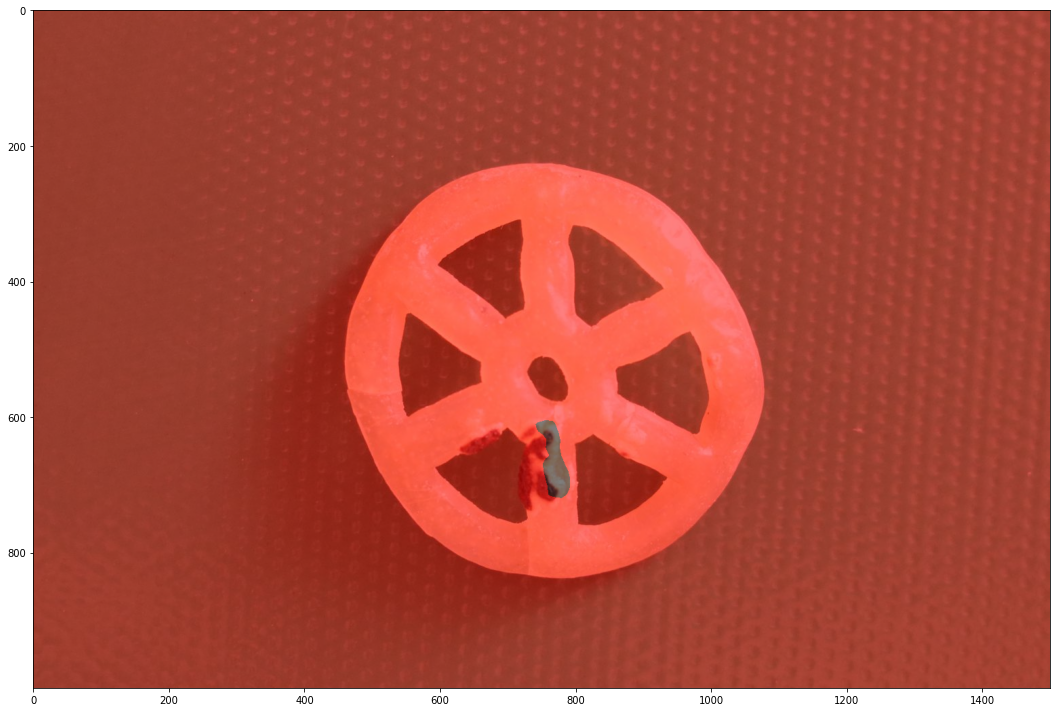

In [ ]:
img = mmcv.imread('/content/test/000.JPG')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)